In [9]:
import numpy as np
import yaml, os
from sys import path
from pathlib import Path
import matplotlib.pyplot as plt

path.append("opereira/starships/cc_scripts/")

import cc_scripts.reduction as red
import cc_scripts.make_model as mod
import cc_scripts.correlations as corr

# unpack input parameters into config dictionary
config_filepath = 'config.yaml'
with open(config_filepath, 'r') as file:
    d = yaml.safe_load(file)

# unpacking variables
pl_name, instrument, visit_name, kind_trans, coeffs, ld_model, kind_res = \
    d['pl_name'], d['instrument'], d['visit_name'], d['kind_trans'], d['coeffs'], d['ld_model'], d['kind_res']

obs_dir, pl_kwargs = d['obs_dir'], d['pl_kwargs']
obs_dir = Path.home() / Path(obs_dir)

# creating the planet and observation objects
p, obs = red.load_planet(pl_name, obs_dir,instrument)

# # Choose which exposures to use
# all_exposures = np.arange(obs.n_spec)
# transit_tags = np.delete(all_exposures, [20, 21, 22, 23, 31, 32, 33])  # Here we exclude the exposures [20, 21, ..., 33]

INFO:starships.planet_obs:Getting WASP-127 b from ExoFile
INFO:starships.planet_obs:Fetching the uncorrected spectra
INFO:starships.planet_obs:File: list_e2ds
INFO:starships.planet_obs:Fetching data
INFO:starships.planet_obs:File: list_tellu_corrected
INFO:starships.planet_obs:Fetching the tellurics
INFO:starships.planet_obs:File: list_tellu_recon


INFO:cc_scripts.make_model:Model not initialized for mode = high. Starting initialization...
INFO:starships.petitradtrans_utils:['H2O_main_iso']
/home/opereira/.venvs/starships-env/lib/python3.11/site-packages/petitRADTRANS/radtrans.py:100: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_main_iso...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...


INFO:starships.petitradtrans_utils:Generating atmosphere with pressures from 100.0 to 1e-10
INFO:starships.petitradtrans_utils:You are not getting the individual contributions of the species
INFO:cc_scripts.make_model:Saving values in `linelist_names`.


Done.

 pRT: negative radius correction applied!


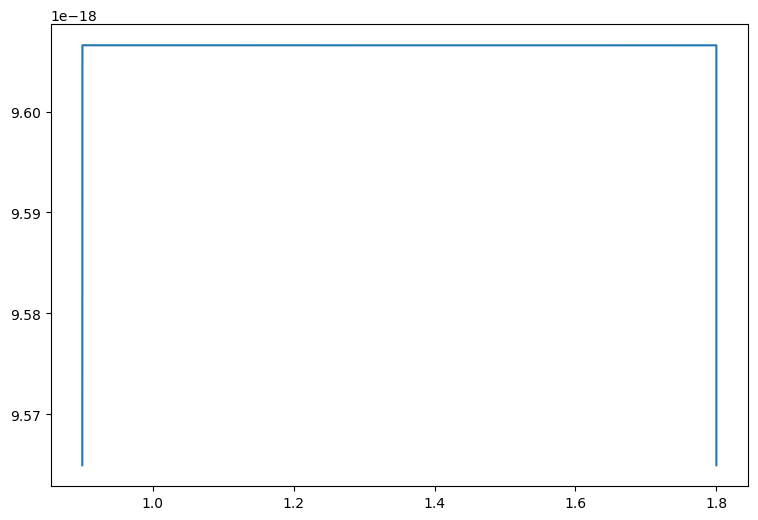

In [30]:
import cc_scripts.make_model as mod
from importlib import reload
mod = reload(mod)

config_filepath = 'config.yaml'
with open(config_filepath, 'r') as file:
    d = yaml.safe_load(file)
    

int_dict = mod.create_internal_dict(d, p)

wv_out, model_out = mod.prepare_model_high_or_low(d, int_dict, d['mode'], p)

plt.plot(wv_out, model_out)

Transmission
Masking high variance pixels (quick fix for OH lines). 
flux_norm all nan : False
Shifting everything in the stellar ref. frame and normalizing by the median 
Spectra 
 Unberv : 74 - 55  
Telluriques 
 Unberv : 74 - 55  
flux_Sref all nan : False
Masking deep tellurics. 
flux_masked all nan : False
Building the master out #1 
ratio_filt has values <= 0.75!
flux_norm_mo all nan : False
master_out all nan : False
Building the transmission spectrum #1 
spec-trans all nan : False
Removing the static noise with PCA and sigma cliping 
(56, 75, 4088)
spec_trans all nan : False
clean_ts all nan : False
Removing the mean 
Removing the remaining high variance pixels. 

Removing the mean. 
Calculating noise with 5 PCs
/scratch/opereira/DataAnalysis/NIRPS-APERO/Reductions/WASP-127b_TEST/retrieval_input_5-pc_mask_wings90_tr1_data_info.npz
/scratch/opereira/DataAnalysis/NIRPS-APERO/Reductions/WASP-127b_TEST/retrieval_input_5-pc_mask_wings90_tr1_data_trs_0.npz


/home/opereira/.venvs/starships-env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 5 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'phi1', 'space']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 873]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 5 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'nonmarkingretur

TypeError: plot_steps() got an unexpected keyword argument 'path'

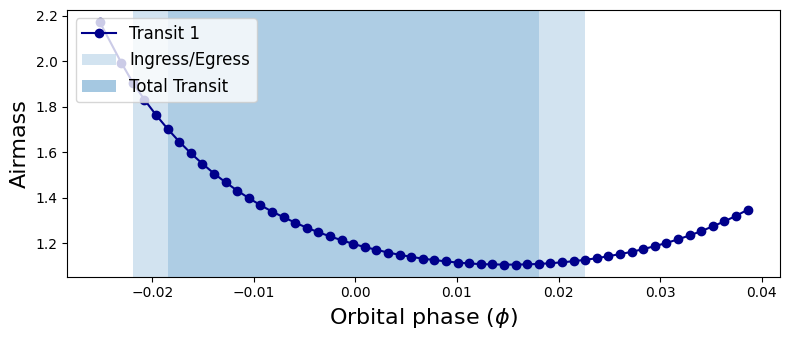

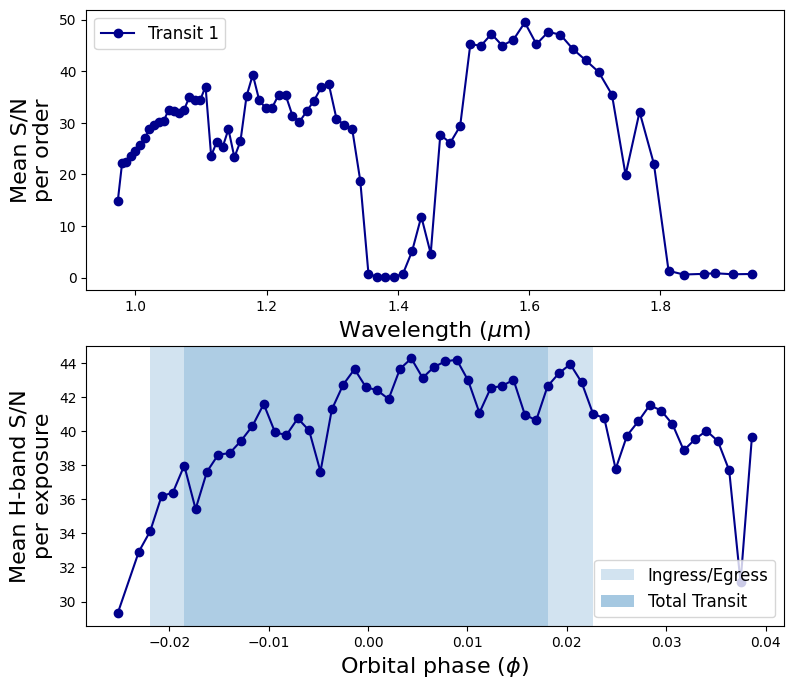

In [5]:
'''---------------------------------------Reducing the Data--------------------------------------'''

reduction, mask_tellu, mask_wings, n_pc, iout_all, clip_ratio, clip_ts, unberv_it, del_exposures = \
    d['reduction'], d['mask_tellu'], d['mask_wings'], d['n_pc'], d['iout_all'], d['clip_ratio'], \
    d['clip_ts'], d['unberv_it'], d['del_exposures']

out_dir, path_fig = red.set_save_location(pl_name, reduction, instrument) # might replace with out_dir from YAML file

# building the transit spectrum
list_tr = red.build_trans_spec(mask_tellu, mask_wings, n_pc, coeffs, ld_model, kind_trans, iout_all, 
                        clip_ratio, clip_ts, unberv_it, obs, p)

# saving the transit spectrum
red.save_pl_sig(list_tr, out_dir, n_pc, mask_wings, visit_name, do_tr = [1])

# outputting plots for reduction step
red.reduction_plots(list_tr, d['idx_ord'], path_fig)

In [3]:
'''-------------------------------------Generating the Model-------------------------------------'''
from importlib import reload
mod = reload(mod)
# computing extra params:
wave_mod, mod_spec = mod.prepare_model_high_or_low(d, d['mode'], d['instrument'], p, atmo_obj=None, fct_star=None,
                              species_dict=None, Raf=None, rot_ker=None)
plt.plot(wave_mod, mod_spec)
plt.savefig(path_fig+'test_model.pdf')

INFO:cc_scripts.make_model:Model not initialized for mode = high. Starting initialization...
INFO:starships.petitradtrans_utils:['H2O_main_iso']


[1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200.
 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200.
 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200.
 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200. 1200.
 1200. 1200.]
<class 'numpy.ndarray'>
float64


/home/opereira/.venvs/starships-env/lib/python3.11/site-packages/petitRADTRANS/radtrans.py:100: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_main_iso...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...


INFO:starships.petitradtrans_utils:Generating atmosphere with pressures from 10000.0 to 1e-12
INFO:starships.petitradtrans_utils:You are not getting the individual contributions of the species
INFO:cc_scripts.make_model:Saving values in `linelist_names`.


Done.

{'gamma_scat': None, 'kappa_factor': None, 'C_to_O': 0.54, 'Fe_to_H': 0, 'specie_2_lnlst': {'H2O': 'H2O_main_iso'}, 'kind_trans': 'transmission', 'dissociation': 'False', 'fct_star': None}


ValueError: failed in converting 2nd argument `temp' of fort_input.interpol_opa_ck to C/Fortran array

In [7]:
import numpy as np
from petitRADTRANS import Radtrans

atmosphere = Radtrans(line_species = ['H2O_HITEMP',
                                      'CO_all_iso_HITEMP',
                                      'CH4',
                                      'CO2',
                                      'Na_allard',
                                      'K_allard'],
                      rayleigh_species = ['H2', 'He'],
                      continuum_opacities = ['H2-H2', 'H2-He'],
                      wlen_bords_micron = [0.3, 15])

pressures = np.logspace(d['limP'][0], d['limP'][1], d['n_pts'])#np.logspace(-6, 2, 100)

atmosphere.setup_opa_structure(pressures)

temperature = 1200 * np.ones_like(pressures)

mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperature)
mass_fractions['He'] = 0.24 * np.ones_like(temperature)
mass_fractions['H2O_HITEMP'] = 0.001 * np.ones_like(temperature)
mass_fractions['CO_all_iso_HITEMP'] = 0.01 * np.ones_like(temperature)
mass_fractions['CO2'] = 0.00001 * np.ones_like(temperature)
mass_fractions['CH4'] = 0.000001 * np.ones_like(temperature)
mass_fractions['Na_allard'] = 0.00001 * np.ones_like(temperature)
mass_fractions['K_allard'] = 0.000001 * np.ones_like(temperature)

MMW = 2.33 * np.ones_like(temperature)

from petitRADTRANS import nat_cst as nc
R_pl = 1.838*nc.r_jup_mean
gravity = 1e1**2.45
P0 = 0.01

atmosphere.calc_transm(temperature, mass_fractions, gravity, MMW, R_pl=R_pl, P0_bar=P0)

  Read line opacities of H2O_HITEMP...
 Done.
  Read line opacities of CO_all_iso_HITEMP...
 Done.
  Read line opacities of CH4...
 Done.
  Read line opacities of CO2...
 Done.
  Read line opacities of Na_allard...
 Done.
  Read line opacities of K_allard...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



In [3]:
import petitRADTRANS as prt

In [6]:
!pip freeze

arviz==0.18.0
astropy==5.3.4+computecanada
astroquery==0.4.7
asttokens==2.2.1+computecanada
attrs==23.2.0+computecanada
backcall==0.2.0+computecanada
backports.tarfile==1.1.1
batman-package==2.4.9
beautifulsoup4==4.12.3+computecanada
bs4==0.0.2
certifi==2024.2.2
cffi==1.15.1+computecanada
charset-normalizer==3.3.2
comm==0.1.4+computecanada
contourpy==1.2.0+computecanada
corner==2.2.2
cryptography==42.0.5+computecanada
cycler==0.12.1+computecanada
debugpy==1.6.7.post1+computecanada
decorator==5.1.1+computecanada
distlib @ file:///tmp/ebuser/avx2/Python/3.11.5/GCCcore-12.3.0/distlib/distlib-0.3.7
dm_tree==0.1.8+computecanada
editables @ file:///tmp/ebuser/avx2/Python/3.11.5/GCCcore-12.3.0/editables/editables-0.5
emcee==3.1.6
executing==1.2.0+computecanada
exo-k==1.1.1
exofile==0.2.2
filelock @ file:///tmp/ebuser/avx2/Python/3.11.5/GCCcore-12.3.0/filelock/filelock-3.12.2
flit_core @ file:///tmp/ebuser/avx2/Python/3.11.5/GCCcore-12.3.0/flit_core/flit_core-3.9.0
fonttools==4.51.0+computecan